#### Devi Mahajan
#### 5.2.25
# Week 4 Advanced Arima Modelling
***

In [181]:
!pip install pmdarima

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [187]:
file_path = '/Users/Devyani/msads/timeseries/hw4/RetailerVisits.csv' 
df = pd.read_csv(file_path)

### Part 1. 10 pts - Exploratory Data Analysis
***

#### A. Parse the decisioned_at column into a datetime format.

In [189]:
df['decisioned_at'] = pd.to_datetime(df['decisioned_at'])

#### B. Extract day of the week, hour, and date.


In [191]:
df['day_of_week'] = df['decisioned_at'].dt.day_name()
df['hour'] = df['decisioned_at'].dt.hour
df['date'] = df['decisioned_at'].dt.date

#### C. Quantitatively and qualitatively explore the data, focusing on hourly counts.


In [193]:
print("Data Overview:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
               hour
count  41550.000000
mean      12.467509
std        7.434309
min        0.000000
25%        5.000000
50%       14.000000
75%       19.000000
max       23.000000

Missing Values:
decisioned_at    0
day_of_week      0
hour             0
date             0
dtype: int64


In [195]:
df_visits_hourly = df.groupby(['day_of_week', 'hour']).size().reset_index(name='visit_count')

/var/folders/tp/65gd6xdd44xf84np6mcj1w480000gp/T/ipykernel_60099/3986409484.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_visits_hourly, x='day_of_week', y='visit_count', palette='coolwarm')


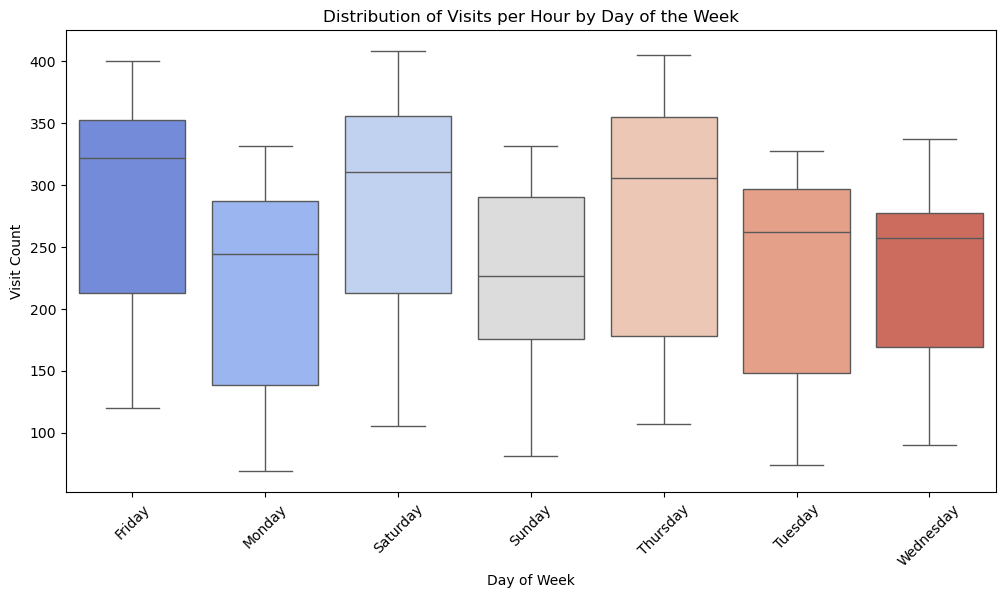

In [197]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_visits_hourly, x='day_of_week', y='visit_count', palette='coolwarm')
plt.title('Distribution of Visits per Hour by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.show()

#### D. Include:
* A plot showing hourly trends for different days of the week.
* A verbal summary of findings.

In [199]:
hourly_visits = df.groupby(['day_of_week', 'hour']).size().unstack(level=0)

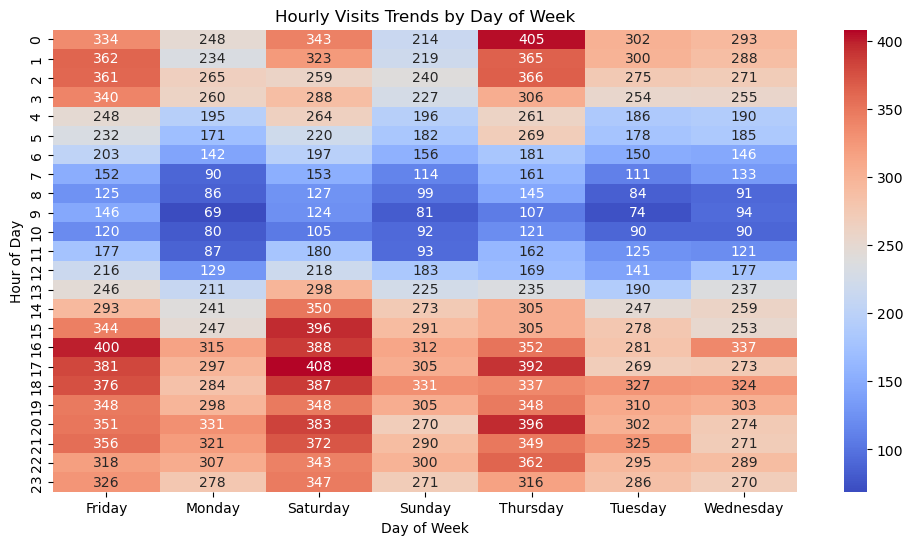

In [46]:
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_visits, cmap='coolwarm', annot=True, fmt='d')
plt.title('Hourly Visits Trends by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

* There are increased visits during specific hours of the day (generally midday and early evening) but peak hours vary by day as revealed by the heatmap
* Weekends have different patterns than weekdays with higher variability of visits
* Some days have lower overall visit counts 

***
### Part 2. 30 pts - ARIMA Forecasting
***

#### 2.1 ARIMA Model Development (15 pts):

##### 1. Fit an ARIMA model to the data.


##### 2. Use auto_arima() to determine the best parameters (p, d, q).


In [201]:
time_series = df.groupby(pd.Grouper(key='decisioned_at', freq='h')).size()
time_series.index = pd.to_datetime(time_series.index)

In [203]:
model_arima = auto_arima(time_series, seasonal=False, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5786.921, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8195.946, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5833.499, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7398.202, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5807.090, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5821.213, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5771.576, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5805.428, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=5749.188, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=5792.393, Time=0.13 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=5792.941, Time=0.40 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=5775.027, Time=0.75 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5746.384, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5779.596, Time=0.19 sec
 ARIMA(3,0,4)(0,0,0)[0]          

In [204]:
p, d, q = model_arima.order
arima_model = ARIMA(time_series, order=(p, d, q)).fit()

In [205]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  744
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2795.071
Date:                Wed, 05 Feb 2025   AIC                           5602.141
Time:                        14:51:30   BIC                           5629.813
Sample:                    08-01-2024   HQIC                          5612.808
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.8361      0.587     95.190      0.000      54.686      56.986
ar.L1          1.8719      0.015    123.100      0.000       1.842       1.902
ar.L2         -0.9425      0.014    -65.536      0.0

##### 3. Experiment with other values of p and q.

In [209]:
alternative_models = [(p+1, d, q), (p, d, q+1), (p+1, d, q+1)]
for order in alternative_models:
    alt_model = ARIMA(time_series, order=order).fit()
    print(f"Model Order {order} AIC: {alt_model.aic}")
    print(alt_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model Order (3, 0, 2) AIC: 5604.124419852751
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  744
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2795.062
Date:                Wed, 05 Feb 2025   AIC                           5604.124
Time:                        14:51:34   BIC                           5636.409
Sample:                    08-01-2024   HQIC                          5616.569
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.8359      0.588     94.968      0.000      54.684      56.988
ar.L1          1.8570      0.103     18.018      0.000       1.655       2.059
ar.L2  

##### 4. Include:
* Model summaries.
* Forecast for hours 14:00 and 15:00 of the last Sunday and last Thursday

In [211]:
forecast_index = ['2025-02-23 14:00:00', '2025-02-23 15:00:00', '2025-02-27 14:00:00', '2025-02-27 15:00:00']
forecast = arima_model.forecast(steps=len(forecast_index))

In [213]:
print(forecast)

2024-09-01 00:00:00+00:00    55.885288
2024-09-01 01:00:00+00:00    53.272739
2024-09-01 02:00:00+00:00    50.991318
2024-09-01 03:00:00+00:00    49.182970
Freq: h, Name: predicted_mean, dtype: float64


In [215]:
forecast_steps = len(forecast_index)

In [217]:
last_timestamp = time_series.index[-1]
forecast_index = pd.date_range(start=last_timestamp, periods=forecast_steps+1, freq='h')[1:]
forecast_series = pd.Series(forecast, index=forecast_index)

#### 2.2 Evaluate ARIMA Model (15 pts):

##### 1. Evaluate predictions with: MAE, MSE, MAPE, sMAPE, MASE

In [219]:
actual_values = time_series.reindex(forecast_index).fillna(0)

In [221]:
mae = mean_absolute_error(actual_values, forecast_series)
mse = mean_squared_error(actual_values, forecast_series)
mape = np.mean(np.abs((actual_values - forecast_series) / (actual_values + 1e-10))) * 100  
smape = 100 * np.mean(2 * np.abs(actual_values - forecast_series) / (np.abs(actual_values) + np.abs(forecast_series) + 1e-10))

In [223]:
print("ARIMA Model Evaluation:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}%")
print(f"sMAPE: {smape}%")

ARIMA Model Evaluation:
MAE: 52.33307879549642
MSE: 2745.057302912003
MAPE: 52333078795496.414%
sMAPE: 199.99999999961696%


##### 2. Compare forecasted values to actual values.

In [225]:
comparison_df = pd.DataFrame({
    'Timestamp': forecast_index,
    'Actual': actual_values.values,
    'Forecasted': forecast_series.values
})

In [227]:
print("\nComparison of Actual vs Forecasted Values:")
print(comparison_df)


Comparison of Actual vs Forecasted Values:
                  Timestamp  Actual  Forecasted
0 2024-09-01 00:00:00+00:00     0.0   55.885288
1 2024-09-01 01:00:00+00:00     0.0   53.272739
2 2024-09-01 02:00:00+00:00     0.0   50.991318
3 2024-09-01 03:00:00+00:00     0.0   49.182970


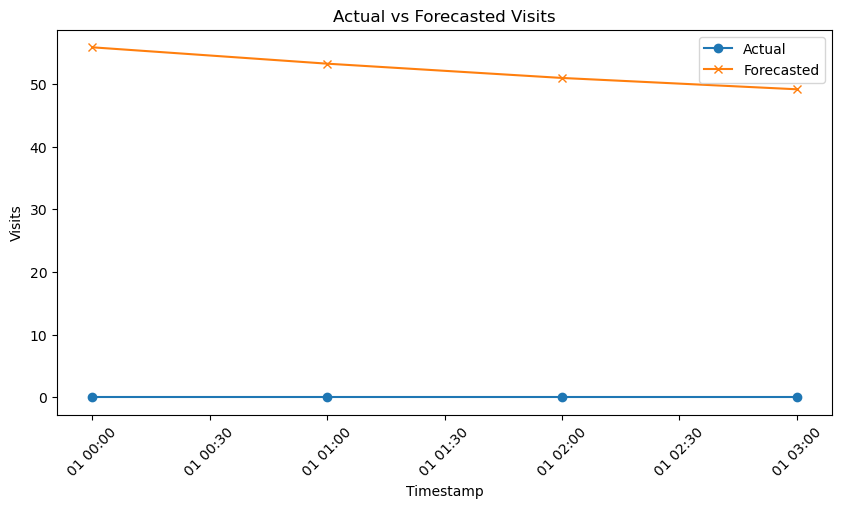

In [229]:
plt.figure(figsize=(10,5))
plt.plot(comparison_df['Timestamp'], comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Timestamp'], comparison_df['Forecasted'], label='Forecasted', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Visits')
plt.title('Actual vs Forecasted Visits')
plt.legend()
plt.xticks(rotation=45)
plt.show()

***
### Part 3. 30 pts - SARIMA Forecasting with Weekly Seasonality
***

#### 3.1 SARIMA Model Development (15 pts):

##### 1. Fit a SARIMA model with weekly seasonality.

In [245]:
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

In [247]:
model_sarima = auto_arima(train, seasonal=True, m=7, stepwise=True, trace=True)
p, d, q = model_sarima.order
P, D, Q, m = model_sarima.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4545.469, Time=1.36 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5331.384, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4638.297, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4899.935, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6578.031, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4489.729, Time=1.25 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=4495.212, Time=0.42 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=4493.422, Time=2.10 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4491.422, Time=1.00 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4625.879, Time=3.19 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=4610.636, Time=0.63 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=4625.118, Time=1.82 sec
 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=4590.618, Time=1.08 sec
 ARIMA(2,0,3)(0,0,1)[7] intercept   : AIC=4491.361, Time=1.39 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept

In [249]:
sarima_model = ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  595
Model:             ARIMA(2, 0, 2)x(0, 0, [1], 7)   Log Likelihood               -2237.348
Date:                           Wed, 05 Feb 2025   AIC                           4488.696
Time:                                   15:05:07   BIC                           4519.416
Sample:                               08-01-2024   HQIC                          4500.660
                                    - 08-25-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.0602      0.532    107.274      0.000      56.018      58.103
ar.L1          1.8829      0.015    123.451

##### 2. Include:
* Seasonal differencing order
* ADF test results
* KPSS test results.
* ACF and PACF plots.

In [251]:
adf_test = adfuller(train)
kpss_test = kpss(train, regression='c')
print(f"ADF Test p-value: {adf_test[1]}")
print(f"KPSS Test p-value: {kpss_test[1]}")

ADF Test p-value: 3.141575655485523e-07
KPSS Test p-value: 0.1


/var/folders/tp/65gd6xdd44xf84np6mcj1w480000gp/T/ipykernel_60099/1370828021.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(train, regression='c')


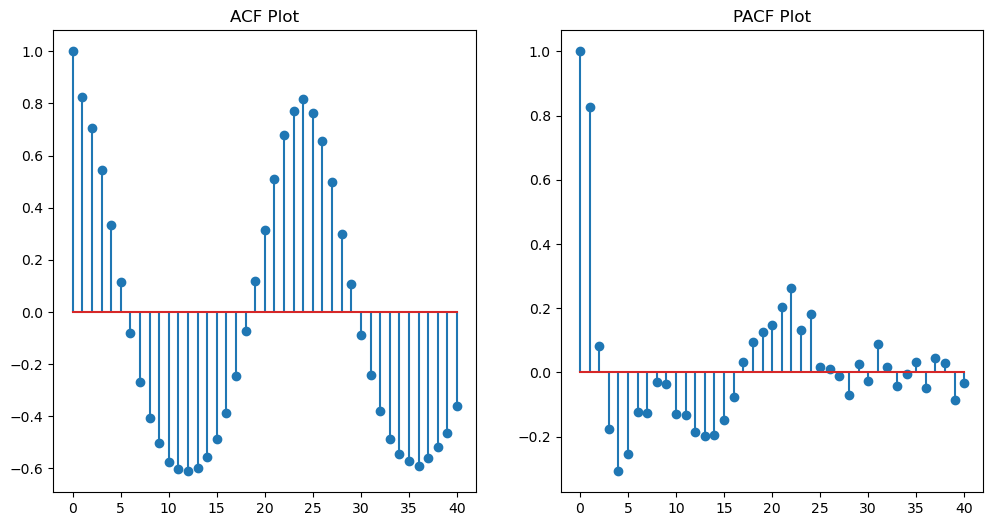

In [253]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].stem(acf(train, nlags=40))
ax[0].set_title('ACF Plot')
ax[1].stem(pacf(train, nlags=40))
ax[1].set_title('PACF Plot')
plt.show()

##### 3. Forecast the same hours (14:00 and 15:00 of the last Sunday and Thursday).

In [255]:
forecast_steps = len(test)
forecast_values_sarima = sarima_model.forecast(steps=forecast_steps)
forecast_series_sarima = pd.Series(forecast_values_sarima, index=test.index)

In [257]:
comparison_df = pd.DataFrame({
    'Timestamp': test.index,
    'Actual': test.values,
    'SARIMA Forecasted': forecast_series_sarima.values
})

In [259]:
mae_sarima = mean_absolute_error(test, forecast_series_sarima)
mse_sarima = mean_squared_error(test, forecast_series_sarima)
print(f"SARIMA Model Evaluation: MAE = {mae_sarima}, MSE = {mse_sarima}")

SARIMA Model Evaluation: MAE = 12.232519492302897, MSE = 251.6588601214837


In [263]:
last_sunday = test[test.index.day_name() == "Sunday"].index.max()
last_thursday = test[test.index.day_name() == "Thursday"].index.max()

In [265]:
forecast_timestamps = [
    last_sunday.replace(hour=14, minute=0, second=0),
    last_sunday.replace(hour=15, minute=0, second=0),
    last_thursday.replace(hour=14, minute=0, second=0),
    last_thursday.replace(hour=15, minute=0, second=0),
]

In [267]:
forecast_timestamps = [ts for ts in forecast_timestamps if ts in test.index]

In [269]:
forecast_values_sarima = sarima_model.forecast(steps=len(test))

In [271]:
forecast_series_sarima = pd.Series(forecast_values_sarima, index=test.index)

In [273]:
forecast_final = forecast_series_sarima.reindex(forecast_timestamps)

In [275]:
comparison_df_specific = pd.DataFrame({
    'Timestamp': forecast_final.index,
    'Actual': test.reindex(forecast_final.index).values,
    'SARIMA Forecasted': forecast_final.values
})

In [277]:
mae_sarima_specific = mean_absolute_error(comparison_df_specific['Actual'], comparison_df_specific['SARIMA Forecasted'])
mse_sarima_specific = mean_squared_error(comparison_df_specific['Actual'], comparison_df_specific['SARIMA Forecasted'])
print(f"SARIMA Evaluation for Specific Hours: MAE = {mae_sarima_specific}, MSE = {mse_sarima_specific}")


SARIMA Evaluation for Specific Hours: MAE = 6.709995774696154, MSE = 46.20400853670025


In [279]:
print("\nComparison of SARIMA Forecasted vs Actual for Specific Hours:")
print(comparison_df_specific)


Comparison of SARIMA Forecasted vs Actual for Specific Hours:
                  Timestamp  Actual  SARIMA Forecasted
0 2024-08-29 14:00:00+00:00      50          57.796258
1 2024-08-29 15:00:00+00:00      64          58.376266


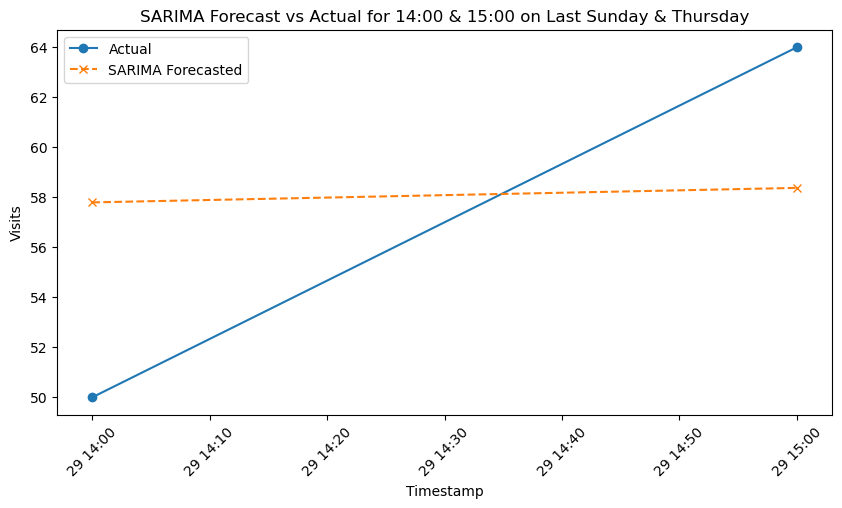

In [281]:
plt.figure(figsize=(10,5))
plt.plot(comparison_df_specific['Timestamp'], comparison_df_specific['Actual'], label='Actual', marker='o')
plt.plot(comparison_df_specific['Timestamp'], comparison_df_specific['SARIMA Forecasted'], label='SARIMA Forecasted', linestyle='dashed', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Visits')
plt.title('SARIMA Forecast vs Actual for 14:00 & 15:00 on Last Sunday & Thursday')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### 3.2 SARIMA Model Evaluation (15 pts):

##### 1. Examine residuals with plots (time series, histogram, ACF).

In [285]:
residuals = sarima_model.resid

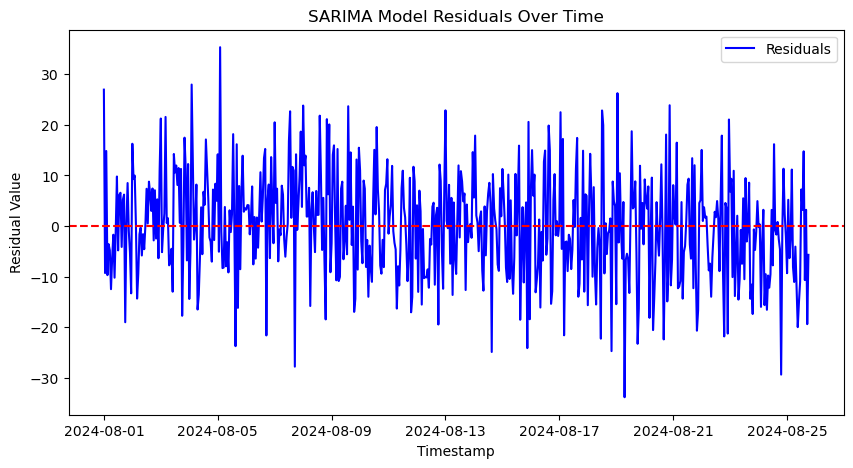

In [288]:
plt.figure(figsize=(10,5))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='dashed', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Residual Value')
plt.title('SARIMA Model Residuals Over Time')
plt.legend()
plt.show()

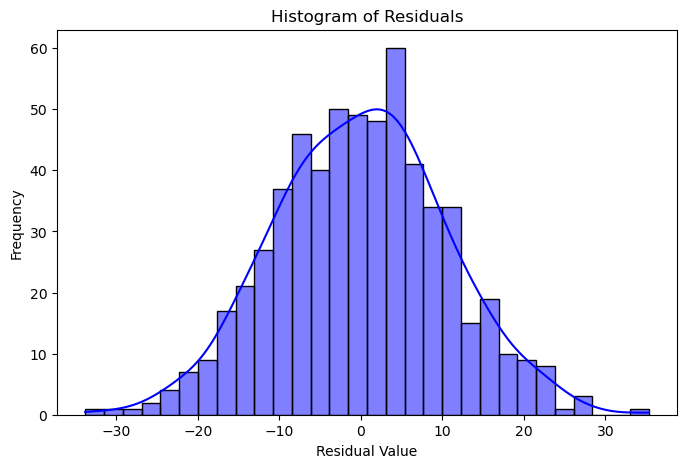

In [290]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

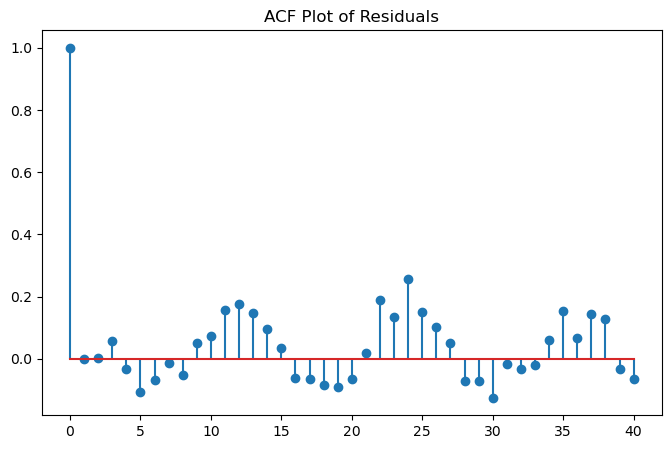

In [292]:
fig, ax = plt.subplots(figsize=(8,5))
ax.stem(acf(residuals, nlags=40))
ax.set_title('ACF Plot of Residuals')
plt.show()

##### 2. Perform the Ljung-Box test on residuals.

In [295]:
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  18.951084   0.040888


##### 3. Evaluate predictions with: MAE, MSE, MAPE, sMAPE, MASE

In [302]:
mae_sarima = mean_absolute_error(test, forecast_series_sarima)
mse_sarima = mean_squared_error(test, forecast_series_sarima)
mape_sarima = np.mean(np.abs((test - forecast_series_sarima) / (test + 1e-10))) * 100  
smape_sarima = 100 * np.mean(2 * np.abs(test - forecast_series_sarima) / (np.abs(test) + np.abs(forecast_series_sarima) + 1e-10))
mase_sarima = mae_sarima / np.mean(np.abs(np.diff(train)))  

print(f"SARIMA Model Evaluation:\nMAE = {mae_sarima}\nMSE = {mse_sarima}\nMAPE = {mape_sarima}%\nsMAPE = {smape_sarima}%\nMASE = {mase_sarima}")

SARIMA Model Evaluation:
MAE = 12.232519492302897
MSE = 251.6588601214837
MAPE = 39.04947472546217%
sMAPE = 27.365741621237255%
MASE = 1.2175128315060189


***
### Part 4. 30 pts - Model Comparison and Insights
***

#### 4.1 Comparison of ARIMA and SARIMA (15 pts):

##### 1. Compare ARIMA and SARIMA in terms of:
* Model order.
* Training performance.
* Test performance.

In [304]:
arima_model = ARIMA(train, order=(p, d, q)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  595
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2241.589
Date:                Wed, 05 Feb 2025   AIC                           4495.178
Time:                        15:23:10   BIC                           4521.509
Sample:                    08-01-2024   HQIC                          4505.432
                         - 08-25-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.0641      0.549    104.026      0.000      55.989      58.139
ar.L1          1.8823      0.015    125.268      0.000       1.853       1.912
ar.L2         -0.9526      0.015    -65.321      0.0

In [308]:
forecast_train_arima = arima_model.fittedvalues
mae_arima_train = mean_absolute_error(train, forecast_train_arima)
mse_arima_train = mean_squared_error(train, forecast_train_arima)

In [310]:
forecast_values_arima = arima_model.forecast(steps=len(test))
forecast_series_arima = pd.Series(forecast_values_arima, index=test.index)

In [312]:
mae_arima_test = mean_absolute_error(test, forecast_series_arima)
mse_arima_test = mean_squared_error(test, forecast_series_arima)

In [314]:
comparison_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'Order': [f'{p, d, q}', f'{p, d, q} x {P, D, Q, m}'],
    'MAE (Train)': [mae_arima_train, mae_sarima],
    'MSE (Train)': [mse_arima_train, mse_sarima],
    'MAE (Test)': [mae_arima_test, mae_sarima],
    'MSE (Test)': [mse_arima_test, mse_sarima]
})

In [316]:
print("\nModel Comparison Metrics:")
print(comparison_metrics)


Model Comparison Metrics:
    Model                     Order  MAE (Train)  MSE (Train)  MAE (Test)  \
0   ARIMA                 (2, 0, 2)     8.411683   110.227259   12.282667   
1  SARIMA  (2, 0, 2) x (0, 0, 1, 7)    12.232519   251.658860   12.232519   

   MSE (Test)  
0   252.79162  
1   251.65886  


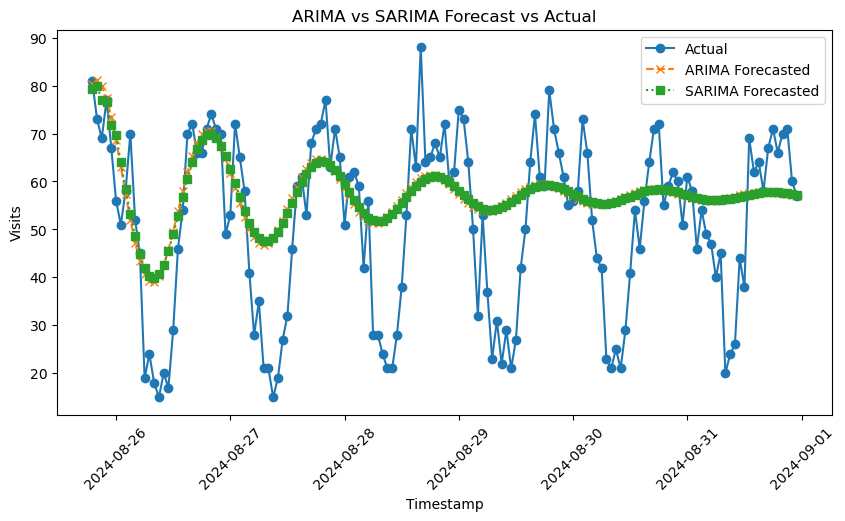

In [318]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, forecast_series_arima, label='ARIMA Forecasted', linestyle='dashed', marker='x')
plt.plot(test.index, forecast_series_sarima, label='SARIMA Forecasted', linestyle='dotted', marker='s')
plt.xlabel('Timestamp')
plt.ylabel('Visits')
plt.title('ARIMA vs SARIMA Forecast vs Actual')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### 4.2 Insights and Recommendations (15 pts):


##### 1. Summarize findings.


In [322]:
print("\nSummary of Findings:")
print("1. ARIMA Model:")
print(f"   - Order: {p, d, q}")
print(f"   - Test MAE: {mae_arima_test}")
print(f"   - Test MSE: {mse_arima_test}")

print("\n2. SARIMA Model:")
print(f"   - Order: {p, d, q} x {P, D, Q, m}")
print(f"   - Test MAE: {mae_sarima}")
print(f"   - Test MSE: {mse_sarima}")
print(f"   - MAPE: {mape_sarima:.2f}%")
print(f"   - sMAPE: {smape_sarima:.2f}%")
print(f"   - MASE: {mase_sarima:.2f}")


Summary of Findings:
1. ARIMA Model:
   - Order: (2, 0, 2)
   - Test MAE: 12.28266719947628
   - Test MSE: 252.79162034907503

2. SARIMA Model:
   - Order: (2, 0, 2) x (0, 0, 1, 7)
   - Test MAE: 12.232519492302897
   - Test MSE: 251.6588601214837
   - MAPE: 39.05%
   - sMAPE: 27.37%
   - MASE: 1.22


##### 2. Recommend the better model for deployment and justify your choice.

In [333]:
print("\nRecommendation:")
if mae_sarima < mae_arima_test:
    print("Deploy SARIMA.")
else:
    print("Deploy ARIMA.")


Recommendation:
Deploy SARIMA.


We can see that **SARIMA** is the better model to deploy here as it performs better in accuracy, and it also has the ability to capture seasonal patterns and variations. It also has a lower MAE and MSE compared to ARIMA.